In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.covariance import EllipticEnvelope
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan


In [2]:
fleet = pd.read_excel('10_1_Class 8 Fleet Data.xlsx', header=0)
efficiency = pd.read_excel('10_2_Class 8 Fleet Fuel Economy.xlsx')
fleet.drop(columns=['Unnamed: 0'], inplace=True)
fleet.drop(index=fleet.index[0], inplace=True)
fleet.columns = fleet.columns.str.strip()

In [3]:
fleet.head()

,Samp. #,Fuel,Soot,Visc,Acid #,Base #,Oxidation,Nitration,Iron,Lead,Copper,Chro,Aluminum,Silicon,Sodium,Potassium,Fuel.1
1,1.0,0.5,0.1,14.1,5.49,4.53,18,24,32,7,1,1,8,6,3,1,#2ULSD
2,2.0,0.5,0.1,14.3,4.85,4.49,14,20,25,4,0,1,6,2,3,2,#2ULSD
3,3.0,0.5,0.1,15.1,3.43,4.69,14,19,26,5,0,1,5,3,2,1,#2ULSD
4,4.0,0.5,0.2,14.6,4.76,4.63,13,18,23,5,1,1,5,5,4,1,#2ULSD
5,5.0,1.2,0.3,14.8,5.89,3.87,20,27,39,14,1,1,7,6,6,1,#2ULSD


In [4]:
efficiency.tail()

,Month,Average Fuel Economy (mpg),Average Fleet % Idle Time,Fleet
19,Aug,3.0,17.5,#2ULSD
20,Sept,3.1,15.0,#2ULSD
21,Oct,3.0,15.0,#2ULSD
22,Nov,2.8,15.0,#2ULSD
23,Dec,2.7,19.0,#2ULSD


In [5]:
fleet.describe()

,Samp. #
count,111.00000
mean,28.27027
std,16.12674
min,1.00000
25%,14.50000
50%,28.00000
75%,42.00000
max,57.00000


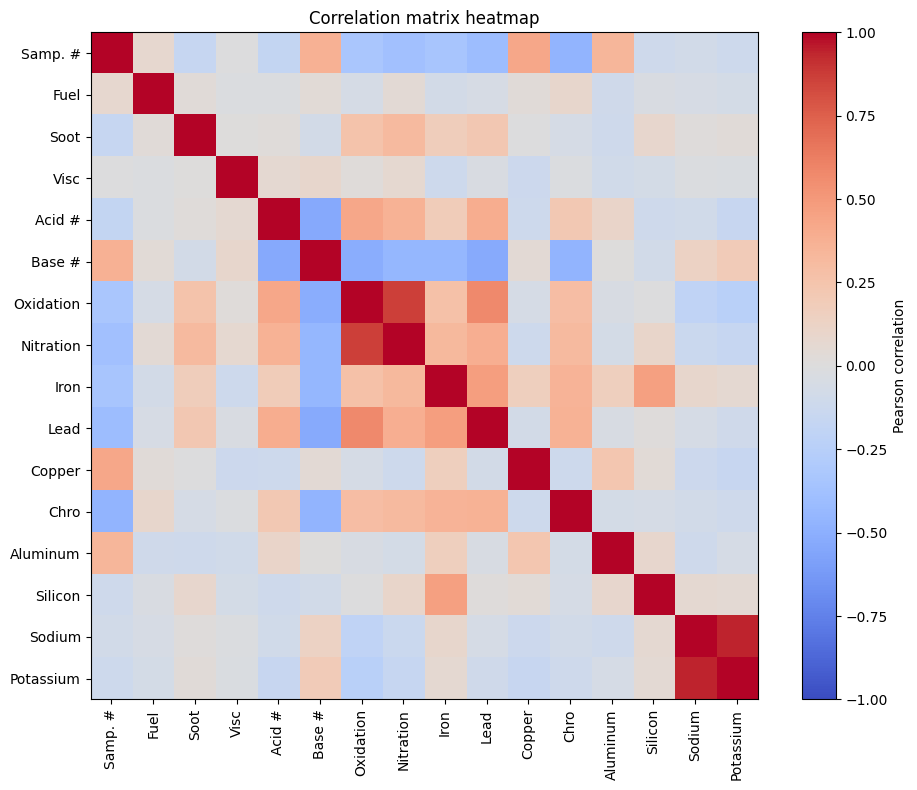

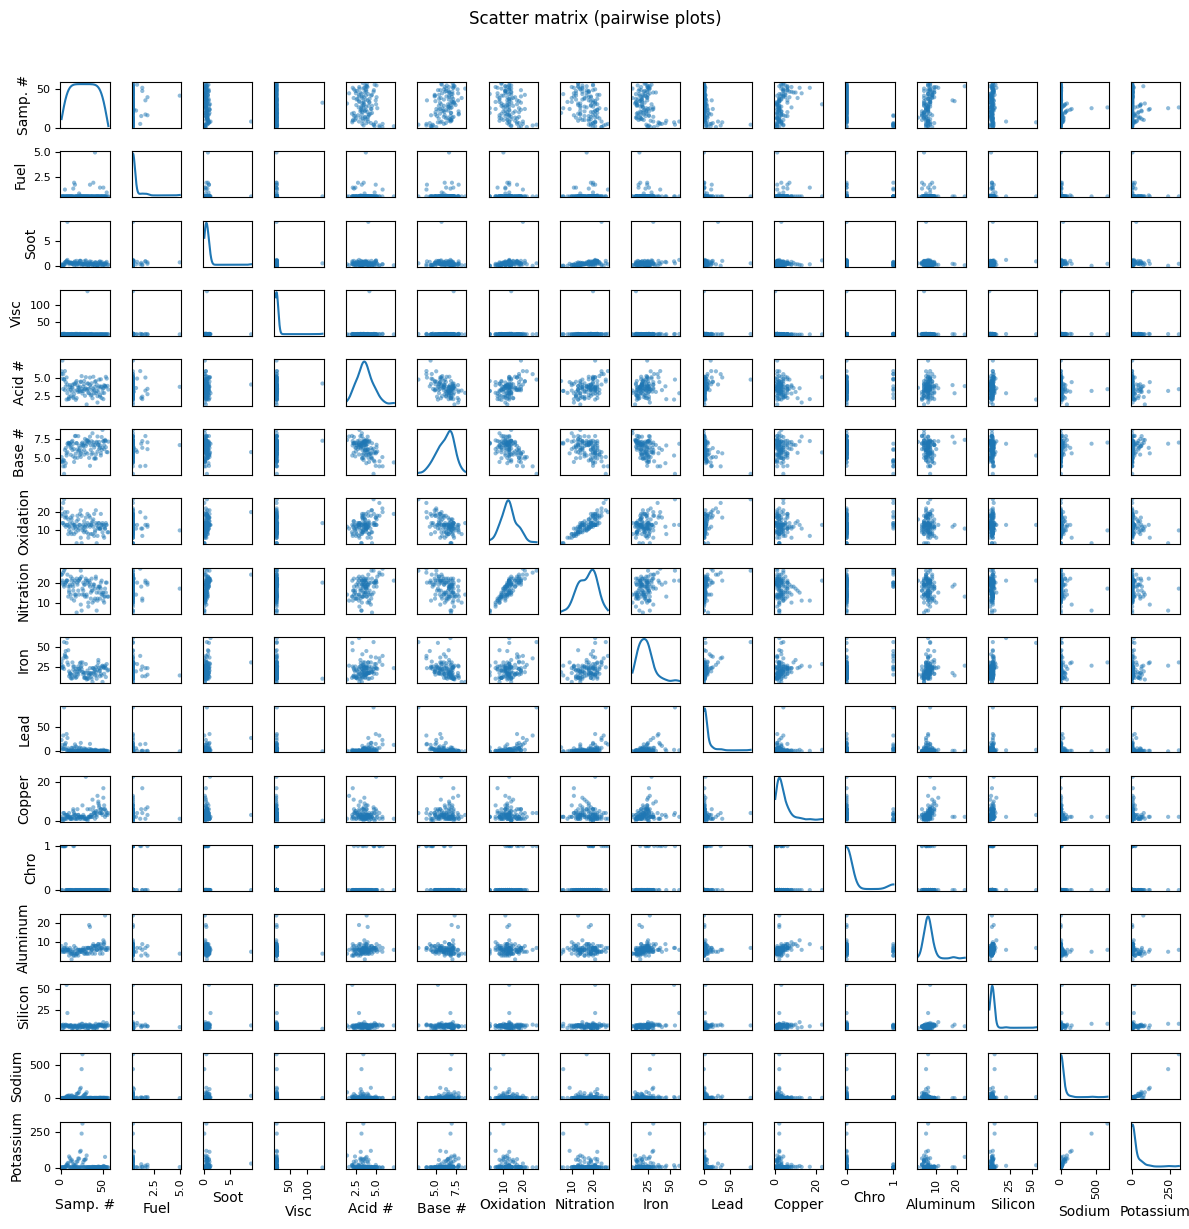

In [6]:
# convert non-numeric values to NaN and compute correlations
numeric = fleet.apply(pd.to_numeric, errors='coerce')

# correlation matrix (drop all-empty columns first)
corr = numeric.dropna(axis=1, how='all').corr()

# heatmap of correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson correlation')
cols = corr.columns
plt.xticks(range(len(cols)), cols, rotation=90)
plt.yticks(range(len(cols)), cols)
plt.title('Correlation matrix heatmap')
plt.tight_layout()
plt.savefig(fname='Heatmap.png')
plt.show()

# pairwise scatter matrix for numeric columns
pd.plotting.scatter_matrix(numeric.dropna(axis=1, how='all'), figsize=(12, 12), diagonal='kde')
plt.suptitle('Scatter matrix (pairwise plots)', y=1.02)
plt.tight_layout()
plt.savefig(fname='pairplot.png')
plt.show()

In [7]:
print('Observations in fleet data: ' + str(len(fleet.index)))
print('Observations in efficiency data: ' + str(len(efficiency.index)))

Observations in fleet data: 111
Observations in efficiency data: 24


In [8]:
wear_metals = ['Iron', 'Lead', 'Copper', 'Chro', 'Aluminum']
wear_metals_corr = corr.loc[wear_metals, wear_metals]
with pd.option_context('display.float_format', '{:.3f}'.format,
                       'display.width', None):
    print(wear_metals_corr)


          Iron   Lead  Copper   Chro  Aluminum
Iron     1.000  0.469   0.159  0.355     0.163
Lead     0.469  1.000  -0.078  0.360    -0.046
Copper   0.159 -0.078   1.000 -0.116     0.232
Chro     0.355  0.360  -0.116  1.000    -0.064
Aluminum 0.163 -0.046   0.232 -0.064     1.000


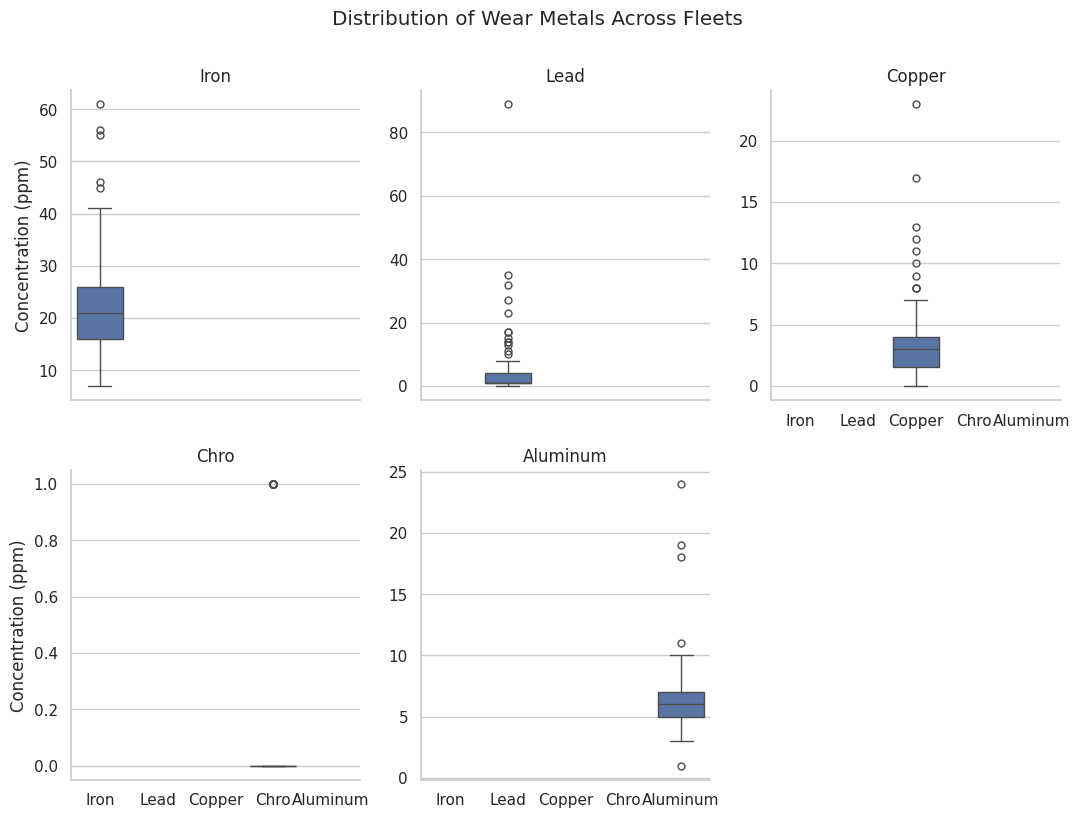

In [9]:
df_long = fleet.melt(
    value_vars=wear_metals,
    var_name="Wear Metal",
    value_name="Concentration"
)
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df_long,
    x="Wear Metal",
    y="Concentration",
    col="Wear Metal",
    kind="box",
    col_wrap=3,
    sharey=False,
    height=4,
    aspect=0.9
)

g.set_titles("{col_name}")
g.set_axis_labels("", "Concentration (ppm)")
g.fig.suptitle("Distribution of Wear Metals Across Fleets", y=1.05)
g.savefig(fname="boxplot.png")
plt.show()

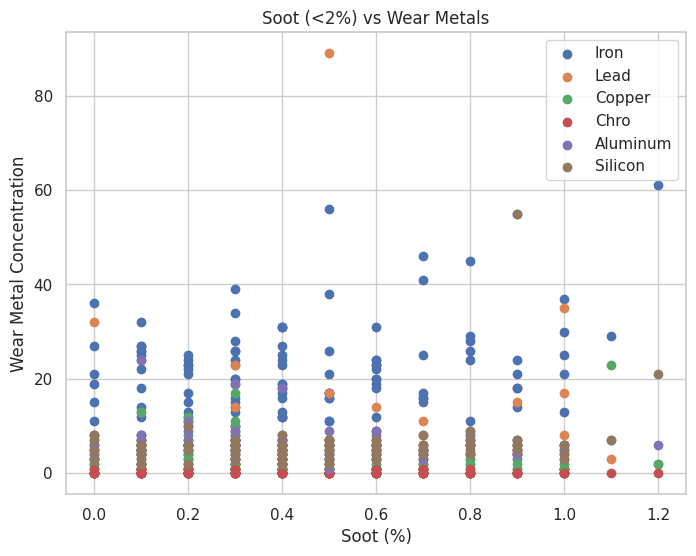

In [10]:


# Filter to soot < 2%
fleet_filtered = fleet[fleet["Soot"] < 2]

# Wear metal columns
wear_metals = [
    "Iron", "Lead", "Copper", "Chro", "Aluminum", "Silicon"
]

plt.figure(figsize=(8, 6))

for metal in wear_metals:
    plt.scatter(fleet_filtered["Soot"], fleet_filtered[metal], label=metal)

plt.xlabel("Soot (%)")
plt.ylabel("Wear Metal Concentration")
plt.title("Soot (<2%) vs Wear Metals")
plt.legend()
plt.grid(True)
plt.savefig(fname="soot.png")
plt.show()

# Investigating the Research Questions

## Research Question 1: Does an increase in degredation indicators affect wear metals
This research question has two predictors and five response variables. We are unable to use linear regression due to more than one response variable. Two-way MANOVA is applicable in this situation as we have two predictors and more than one response variable. 

In [11]:
formula = 'Iron + Lead + Copper + Chro + Aluminum + Silicon ~ Oxidation + Nitration'
predictors = ['Oxidation','Nitration']

manova_df = fleet[predictors + wear_metals].copy().apply(pd.to_numeric, errors='coerce').dropna()
manova_df[wear_metals] = np.log1p(manova_df[wear_metals])
detector = EllipticEnvelope(contamination=0.06, random_state=42) # Removes significant outliers


manova_df['is_outlier'] = detector.fit_predict(manova_df[wear_metals])

manova_df = manova_df[manova_df['is_outlier'] == 1]

maov = MANOVA.from_formula(formula, data=manova_df)
print(maov.mv_test())


                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value  Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.0937 6.0000 96.0000 154.7053 0.0000
         Pillai's trace 0.9063 6.0000 96.0000 154.7053 0.0000
 Hotelling-Lawley trace 9.6691 6.0000 96.0000 154.7053 0.0000
    Roy's greatest root 9.6691 6.0000 96.0000 154.7053 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Oxidation        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.5338 6.0000 96.0000 13.9723 0.0000
          Pillai's trace 0.4662 6.0000 96.0000 13.9723 0.0000
  Hotelling-Lawley trace 0

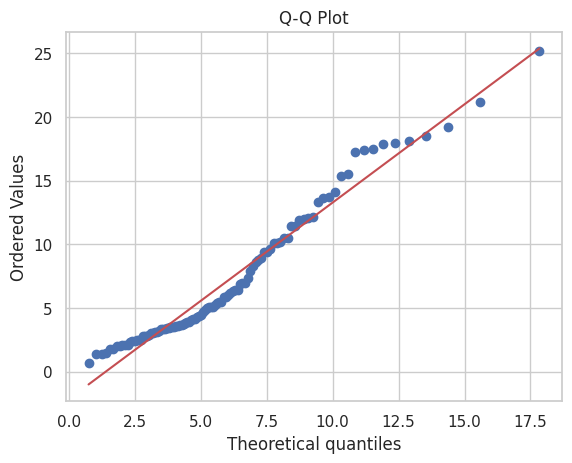

In [30]:
mahal_distances = detector.mahalanobis(manova_df[wear_metals])
stats.probplot(mahal_distances, dist="chi2", sparams=(len(wear_metals),), plot=plt)
plt.title("Q-Q Plot")
plt.savefig("Q1_qq.png")
plt.show()


## Assumptions
1. Multivariate Normality 

Based on the Q-Q graph we can see that the response variables are multivariate normally distributed within each group after the log transformation

2. Independence

Can be assumed based on the context of the dataset.

3. Equal Variance

The test statistic for Pillai's Trace is significant and large enough for unequal variance to be unimportant, as the test statistic is resiliant to unequal variance.

4. No outliers

We address this using SciKit Learn's Eliptic Envelope function to remove substantial outliers.

## Hypothesis test

### Hypotheses
$H_0$ for Oxidation: The vector of regression coefficients will be zero for all six wear metals, meaning Oxidation has no effect on the presence of wear metals.
$H_0$ for Nitration: The vector of regression coefficients will be zero for all six wear metals, meaning Nitration has no effect on the presence of wear metals.

$H_1$: At least one of the six coefficients for a given predictor is not zero for either Nitration, Oxidation, or both.

### Test Statistics
The MANOVA produces several multivariate test statistics, each yielding identical F and p values. For Oxidation we observed an F value of 13.9 with a p-value of 0. For nitration we observe an F value of 6.99 and a p-value of 0.

### Conclusion
We reject both null hypotheses as both our p values are below our alpha significance level. We are not able to isolate which of the wear metals are associated with oxidation and nitration, so we will follow up this test with individual univariate ANOVAs with the Bonferroni Correction.

In [13]:

X = sm.add_constant(manova_df[predictors])

results = {}
for metal in wear_metals:
    model = sm.OLS(manova_df[metal], X).fit()
    results[metal] = model

for metal in wear_metals:
    print(f"\n{metal}:")
    print(f"  Oxidation p = {results[metal].pvalues['Oxidation']:.4f}")
    print(f"  Nitration p = {results[metal].pvalues['Nitration']:.4f}")


Iron:
  Oxidation p = 0.7796
  Nitration p = 0.1469

Lead:
  Oxidation p = 0.0000
  Nitration p = 0.0062

Copper:
  Oxidation p = 0.1673
  Nitration p = 0.0597

Chro:
  Oxidation p = 0.6530
  Nitration p = 0.1926

Aluminum:
  Oxidation p = 0.2193
  Nitration p = 0.2182

Silicon:
  Oxidation p = 0.6611
  Nitration p = 0.6443


Using an updated $\alpha$ of .05/6=.0083 as per our Bonferroni Correction, we can observe that the only significant interaction is between Lead-Oxidation and Lead-Nitration, for which we will reject the null hypothesis as we have strong evidence of an effect. For all other results we fail to reject the null hypothesis under the stricter significance value.

## Research Question 2: Does soot increasing correspond to more engine wear metals: 
We will use a one-way MANOVA to test one predictor against five responses

In [14]:
one_way_df = fleet[['Soot'] + wear_metals].copy()
one_way_df[wear_metals] = one_way_df[wear_metals].astype(float)
one_way_df['Soot'] = pd.to_numeric(one_way_df['Soot'], errors='coerce')
one_way_df[wear_metals] = one_way_df[wear_metals].apply(pd.to_numeric, errors='coerce')
one_way_df[wear_metals] = np.log1p(one_way_df[wear_metals])
soot_threshold = one_way_df['Soot'].quantile(0.99)
one_way_df = one_way_df[one_way_df['Soot'] <= soot_threshold]

detector = EllipticEnvelope(contamination=0.05, random_state=42) # Removes significant outliers
one_way_df['is_outlier'] = detector.fit_predict(one_way_df[wear_metals])

one_way_df = one_way_df[one_way_df['is_outlier'] == 1]


formula = 'Iron + Lead + Copper + Chro + Aluminum + Silicon ~ Soot'
maov = MANOVA.from_formula(formula, data=one_way_df)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0254 6.0000 96.0000 614.7153 0.0000
         Pillai's trace  0.9746 6.0000 96.0000 614.7153 0.0000
 Hotelling-Lawley trace 38.4197 6.0000 96.0000 614.7153 0.0000
    Roy's greatest root 38.4197 6.0000 96.0000 614.7153 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
            Soot          Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8393 6.0000 96.0000  3.0636 0.0087
           Pillai's trace 0.1607 6.0000 96.0000  3.0636 0.0087
   Hotellin

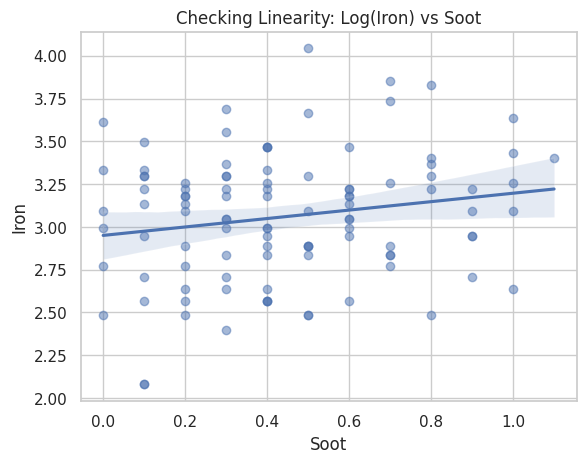

In [31]:
sns.regplot(data=one_way_df, x='Soot', y='Iron', scatter_kws={'alpha':0.5})
plt.title("Checking Linearity: Log(Iron) vs Soot")
plt.savefig("Q2-linearity")
plt.show()

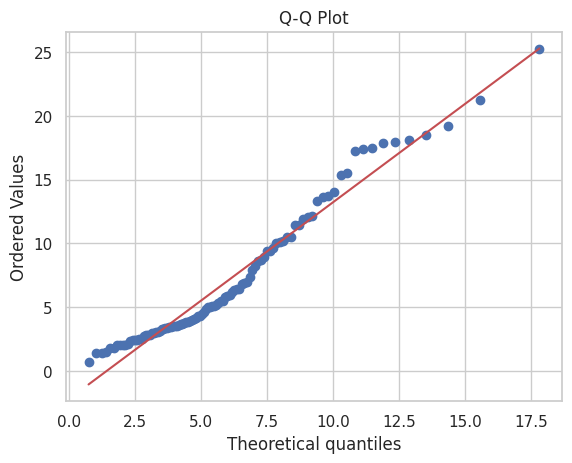

In [33]:
mahal_distances = detector.mahalanobis(one_way_df[wear_metals])
stats.probplot(mahal_distances, dist="chi2", sparams=(len(wear_metals),), plot=plt)
plt.title("Q-Q Plot")
plt.savefig("Q2-qq.png")
plt.show()


## Assumptions
1. Multivariate Normality 

Based on the Q-Q graph we can see that the response variables are multivariate normally distributed within each group after the log transformation

2. Independence

Can be assumed based on the context of the dataset.

3. Equal Variance

The test statistic for Pillai's Trace is significant and large enough for unequal variance to be unimportant, as the test statistic is resiliant to unequal variance.

4. No outliers

We address this using SciKit Learn's Eliptic Envelope function to remove substantial outliers.

## Hypotheses
$H_0$: Soot has no effect on wear metals, and the coefficients will be 0 for all wear metals. 
$H_1$: Soot has an effect on wear metals, and at least one coefficient will not be 0.

## Test Statistics
A one way MANOVA was performed comparing Soot to wear metals. We observed an F value of 3.06 and a p of .008. We observed a Pillai's trace of .16, meaning about 16% of the variance in wear metals can be explained by soot.

## Conclusion
At a significance level of $\alpha = .05$, we reject the null hypothesis, as we have sufficient evidence at the 95% confidence level that soot has an effect on the log concentration of wear metals.

## Research Question 3: Do wear metals increase linearly or non-linearly: 
For this question I will assess model fit for a linear model with quadratic term to determine if the relationship is linear.

In [29]:
def test_wear_trends(df):
    results = []
    working_df = df.copy()
    
    for metal in wear_metals:
        working_df[metal] = pd.to_numeric(working_df[metal], errors='coerce')
        temp_df = working_df.dropna(subset=[metal, 'Samp. #']).copy()
        temp_df['log_metal'] = np.log1p(temp_df[metal])
        
        temp_df['time_step'] = temp_df['Samp. #']
        temp_df['time_step_sq'] = temp_df['time_step']**2
        
        try:

            formula = 'log_metal ~ time_step + time_step_sq'
            model = smf.ols(formula=formula, data=temp_df).fit()
            
            p_val_linear = model.pvalues['time_step']
            p_val_quad = model.pvalues['time_step_sq']
            coeff_quad = model.params['time_step_sq']
            
            if p_val_quad < 0.05:
                trend = "Quadratic" if coeff_quad > 0 else "Curved"
            else:
                trend = "Linear" if p_val_linear < 0.05 else "No Significant Trend"
                
            results.append({
                'Metal': metal,
                'Result': trend,
                'P_Linear': round(p_val_linear, 4),
                'P_Quadratic': round(p_val_quad, 4),
                'R_squared': round(model.rsquared, 4)
            })
        except Exception as e:
            results.append({'Metal': metal, 'Result': f"Error: {str(e)}"})
            
    return pd.DataFrame(results)

test_wear_trends(fleet)

,Metal,Result,P_Linear,P_Quadratic,R_squared
0,Iron,Quadratic,0.0000,0.0000,0.2461
1,Lead,Quadratic,0.0001,0.0209,0.3359
2,Copper,No Significant Trend,0.6468,0.2561,0.2775
3,Chro,Quadratic,0.0000,0.0000,0.3662
4,Aluminum,Quadratic,0.2508,0.0247,0.1777
5,Silicon,Quadratic,0.0181,0.0163,0.0524


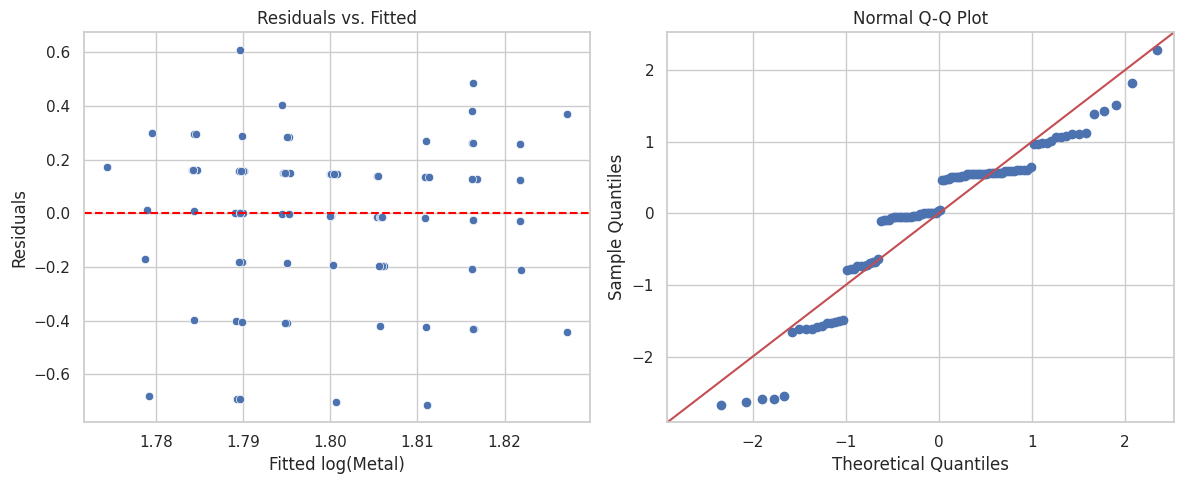

In [34]:

residuals = model.resid
fitted = model.fittedvalues

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=fitted, y=residuals, ax=ax[0])
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title('Residuals vs. Fitted')
ax[0].set_xlabel('Fitted log(Metal)')
ax[0].set_ylabel('Residuals')

sm.qqplot(residuals, line='45', fit=True, ax=ax[1])
ax[1].set_title('Normal Q-Q Plot')

plt.tight_layout()
plt.savefig('Q3-diagnostics.png')
plt.show()

## Assumptions
1. Linearity
While this model does contain a quadratic term, the linearity assumption only cares about linearity of coefficients. The residual plot shows no patterns, is roughly symmetrical around 0, and has no U shape or bow. This assumption is met.

2. Independence
Assumed from dataset context.

3. Normality
While the Q-Q plot has a quirk of being step-like, this is likely due to the data being not truly continuous. This is not violated under log-normality.

4. Equal Variance of Residuals
In the above graph, we can see that there is no clear pattern in the residuals. This is met.

## Hypotheses
$H_0$: $\beta_{quadratic}=0$, the relationship between time and log-metal concentration is linear

$H_1: \beta_{quadratic}\neq 0$, the relationship between time and log-metal concentration is non-linear

## Conclusion
For Iron, Lead, Chromium, Aluminum, and Silicon, we observe p values < .05, therefore we reject the null hypothesis for these metals, and the relationship is significantly non-linear. For copper we fail to reject the null as we do not have sufficient evidence to suggest a non-linear trend in the data. $R^2$ values were low across the board however, meaning while there is a significant effect, there is still a large amount of noise, which is to be expected on fleet data where daily operating conditions can change dramatically.